## Text Classification_Transformer Encoder
<br>

#### 필요 라이브러리 가져오기
<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

<br>

#### 데이터 가져오기
<br>

In [2]:
# train 데이터 로드
train_data_aug = pd.read_csv('./data/train_aug.csv')

In [3]:
print('훈련용 텍스트 개수 :',len(train_data_aug))

훈련용 텍스트 개수 : 15800


<br>

#### 데이터 정제 및 토큰화
<br>

In [37]:
# 중복 데이터 제거(conversation 열)

In [4]:
train_data_aug.drop_duplicates(subset=['conversation'], inplace=True)
train_data_aug = train_data_aug.dropna(how='any')

In [5]:
print('훈련 데이터의 대화문 수:',len(train_data_aug))

훈련 데이터의 대화문 수: 15624


<br>

In [42]:
# 레이블 결측 여부 확인(class 열)

In [6]:
train_data_aug = train_data_aug.dropna(subset=['class'])

In [7]:
print(train_data_aug['class'].unique())

['직장 내 괴롭힘 대화' '기타 괴롭힘 대화' '갈취 대화' '협박 대화']


<br>

In [45]:
# 레이블 값 변경(문자열 -> 숫자)

In [8]:
# 레이블 값을 숫자로 매핑
label_mapping = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3
}

In [9]:
# 훈련용 데이터(train_data_aug)의 레이블 값을 숫자로 변환
train_data_aug['class'] = train_data_aug['class'].map(label_mapping)

<br>

In [49]:
# Tokenization

In [10]:
tokenizer = Tokenizer(num_words=20000)

In [11]:
# 훈련용 데이터 tokenization
tokenizer.fit_on_texts(train_data_aug['conversation'])

In [12]:
train_X = tokenizer.texts_to_sequences(train_data_aug['conversation'])
train_X = pad_sequences(train_X, maxlen=200)
train_y = train_data_aug['class'].values

In [13]:
train_X

array([[    0,     0,     0, ..., 13571,   263,    81],
       [    0,     0,     0, ..., 13571,   263,    81],
       [    0,     0,     0, ..., 13571,   263,    81],
       ...,
       [    0,     0,     0, ...,    35,  1590,    25],
       [    0,     0,     0, ...,    35,  1590,    25],
       [    0,     0,     0, ...,    35,  1590,    25]], dtype=int32)

In [14]:
train_y

array([2, 2, 2, ..., 3, 3, 3])

<br>

In [16]:
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

In [17]:
print(f"Training data size: {len(train_X)}")
print(f"Validation data size: {len(val_X)}")

Training data size: 12499
Validation data size: 3125


<br>

#### positional encoding
<br>

In [18]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn  # Attention 시각화 용도

print(tf.__version__)

2.6.0


In [19]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

<br>

In [20]:
!pip install altair

In [21]:
import pandas as pd
import altair as alt

In [22]:
def plot_positional_encodings():
    y = positional_encoding(100, 20)
    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[:, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    chart = (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )
    
    return chart

In [23]:
plot_positional_encodings()

alt.Chart(...)

<br>

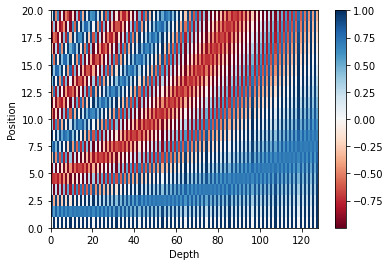

In [24]:
sample_pos_encoding = positional_encoding(20, 512)

plt.pcolormesh(sample_pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

<br>

#### Transformer 모델 구성
<br>

In [25]:
# 멀티 헤드 어텐션 클래스

In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads
        assert embedding_dim % self.num_heads == 0
        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)

        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

<br>

In [27]:
# 트랜스포머 블록 클래스

In [28]:
class TransformerBlock(tf.keras.layers.Layer):

    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)  # 첫 번째 서브층: 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Add & Norm
        ffn_output = self.ffn(out1)  # 두 번째 서브층: 포지션 와이즈 피드포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Add & Norm

<br>

In [29]:
# 토큰 및 포지션 임베딩 클래스

In [30]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):

    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

<br>

#### 모델 구현 및 학습
<br>

In [31]:
# 모델 구현 및 설정

In [32]:
vocab_size = 20000
max_len = 200
embedding_dim = 32
num_heads = 2
dff = 32

In [33]:
from tensorflow.keras.callbacks import EarlyStopping

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)

transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)

outputs = tf.keras.layers.Dense(4, activation="softmax")(x)  # 4개의 클래스로 분류

In [34]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [35]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

<br>

In [36]:
# 학습

In [37]:
history = model.fit(
    train_X, train_y,
    batch_size=32,
    epochs=5,
    validation_data=(val_X, val_y),
    callbacks=[early_stopping]
)

Epoch 1/5
391/391 [==============================] - 6s 10ms/step - loss: 0.7620 - accuracy: 0.6603 - val_loss: 0.0726 - val_accuracy: 0.9798
Epoch 2/5
391/391 [==============================] - 4s 9ms/step - loss: 0.0400 - accuracy: 0.9906 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 3/5
391/391 [==============================] - 3s 9ms/step - loss: 0.0037 - accuracy: 0.9998 - val_loss: 1.3200e-04 - val_accuracy: 1.0000
Epoch 4/5
391/391 [==============================] - 3s 9ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 5.1863e-05 - val_accuracy: 1.0000
Epoch 5/5
391/391 [==============================] - 4s 9ms/step - loss: 6.2589e-04 - accuracy: 1.0000 - val_loss: 2.1950e-05 - val_accuracy: 1.0000


In [38]:
print("훈련 정확도: %.4f" % (model.evaluate(train_X, train_y)[1]))

391/391 [==============================] - 2s 4ms/step - loss: 1.0326e-05 - accuracy: 1.0000
훈련 정확도: 1.0000


<br>

#### 훈련 과정 시각화
<br>

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

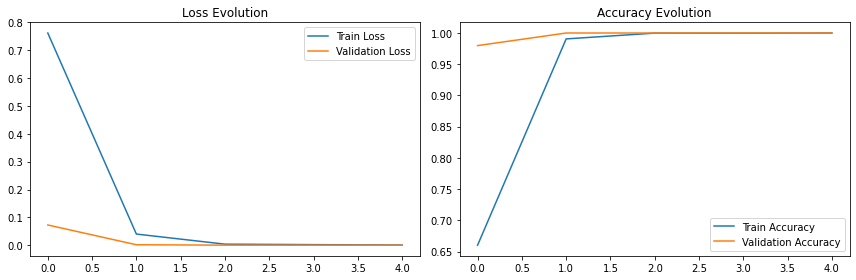

In [40]:
# 훈련과정 그래프
def plot_training_history(history):
    # Loss plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Evolution')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Evolution')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

<br>

#### 평가 및 성능지표
<br>

In [41]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns

In [42]:
# 모델을 사용하여 예측 수행
val_predictions = np.argmax(model.predict(val_X), axis=-1)

In [43]:
# f1 score 출력
f1 = f1_score(val_y, val_predictions, average='macro')
print(f"F1 Score: {f1}\n")

F1 Score: 1.0



<br>

In [44]:
# classification report 출력
report = classification_report(val_y, val_predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       716
           1       1.00      1.00      1.00       756
           2       1.00      1.00      1.00       818
           3       1.00      1.00      1.00       835

    accuracy                           1.00      3125
   macro avg       1.00      1.00      1.00      3125
weighted avg       1.00      1.00      1.00      3125



<br>

In [45]:
# confusion matrix 시각화
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm_norm, annot=cm, fmt='g', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

In [46]:
# 클래스 라벨 
classes = ["class_0", "class_1", "class_2", "class_3"]

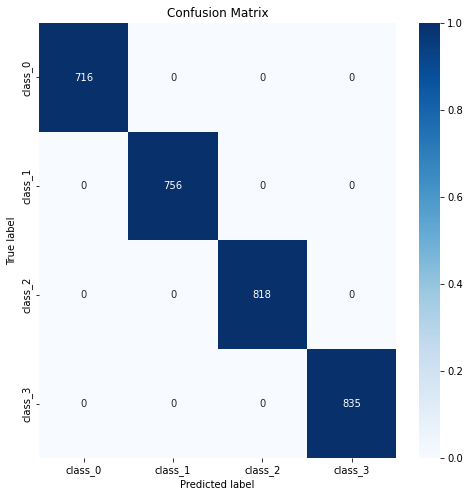

In [47]:
plot_confusion_matrix(val_y, val_predictions, classes)

<br>

In [48]:
# prediction

In [49]:
def multi_class_predict(new_sentence):
    new_sentence = tokenizer.texts_to_sequences([new_sentence])
    new_sentence = pad_sequences(new_sentence, maxlen=max_len)

    score = model.predict(new_sentence)[0]

    class_names = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']
    max_score_index = np.argmax(score)
    predicted_class = class_names[max_score_index]
    probability = score[max_score_index] * 100  # 확률을 %로 변환

    print("해당 문장은 {:.2f}%의 확률로 '{}'로 분류됩니다.".format(probability, predicted_class))

In [50]:
multi_class_predict("참 애매하시네요.")

해당 문장은 99.18%의 확률로 '기타 괴롭힘 대화'로 분류됩니다.


In [68]:
multi_class_predict("돈 내놔")

해당 문장은 99.95%의 확률로 '갈취 대화'로 분류됩니다.


<br>

#### test.json 파일 예측 및 submission 파일 생성
<br>

In [52]:
import pandas as pd

# JSON 파일을 dataframe으로 로드
df = pd.read_json('./data/test.json')
df_flipped = df.transpose()

# 처음 5행 출력
df_flipped.head()

pd.set_option('display.max_rows', 500)
df_flipped

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...
t_005,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...
t_006,그 사람 누구냐? 누구말하는거야? 다 알면서 모른척 하지마. 둘다 쏴버리기 전에...
t_007,야 저기야 닭꼬치 트럭왔다 응 그러네 그치? 너도 먹고 싶지? 어?나도? 그래 너 ...
t_009,야 너 2학년 김민석 맞지? 네 맞는데요. 혹시 누구신가요? 내가 누군지 궁금하면 ...
t_010,예전에 네가 나한테 했던 일 기억하지? 너도 당해봐 예전 일이라면 내가 사과할게. ...
t_012,김비서 지금 우리애 학교가서 집에다가 좀 데려다 주세요 사장님 그런 개인적인 일은 ...


In [53]:
def get_predicted_class(new_sentence):
    new_sentence = tokenizer.texts_to_sequences([new_sentence])
    new_sentence = pad_sequences(new_sentence, maxlen=max_len)

    score = model.predict(new_sentence)[0]

    class_names = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화']
    predicted_class = class_names[np.argmax(score)]

    return predicted_class

In [54]:
# 예측된 클래스 값에 따른 매핑 생성
class_mapping = {
    '협박 대화': '00',
    '갈취 대화': '01',
    '직장 내 괴롭힘 대화': '02',
    '기타 괴롭힘 대화': '03'
}

In [55]:
# df_flipped의 각 문장에 대해 예측 클래스를 얻습니다.
df_flipped['predicted_class'] = df_flipped['text'].apply(get_predicted_class)

In [56]:
# 예측된 클래스를 코드로 매핑
df_flipped['class'] = df_flipped['predicted_class'].map(class_mapping)

In [57]:
df_flipped.drop(columns=['text'], inplace=True)
df_flipped.drop(columns=['predicted_class'], inplace=True)

In [58]:
# 변환된 dataframe의 처음 5행 출력(확인용)
print(df_flipped.head())

      class
t_000    03
t_001    02
t_002    02
t_004    03
t_005    00


In [59]:
# 변환된 dataframe의 처음 5행 출력(확인용)
df_flipped.head()

,class
t_000,03
t_001,02
t_002,02
t_004,03
t_005,00


In [60]:
# 'class' 열의 값을 두 자리 숫자로 변환
df_flipped['class'] = df_flipped['class'].astype(int).apply(lambda x: f"{x:02}")

# 변환된 dataframe의 처음 5행 출력(확인용)
df_flipped.head()

,class
t_000,03
t_001,02
t_002,02
t_004,03
t_005,00


In [61]:
import datetime

# 현재 날짜와 시간 가져오기
now = datetime.datetime.now()

# 날짜와 시간을 원하는 형식으로 포맷팅
date_time_str = now.strftime("%Y%m%dT%H%M")

# 파일명 생성
file_name = f"submission{date_time_str}.csv"

# submission.csv 파일을 날짜패턴 합쳐 만들기
df_flipped.to_csv(file_name)